## 난임 환자 대상 임신 성공 여부 예측

### LGAimers 6th 온라인 해커톤

### Import

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

In [4]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # 평가
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    cm = confusion_matrix(y_test, y_pred)
    
    # 결과 출력
    print()
    print("--- Model Performance ---")
    print(f"Model Accuracy: {accuracy}")
    print(f"Model F1 Score: {f1}")
    print(f"Model AUC: {auc}")
    
    # 혼동 행렬 출력
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    
    return y_pred, y_pred_proba

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import platform
from matplotlib import rc

# 운영 체제에 따라 폰트 설정
if platform.system() == 'Windows':  # Windows 환경
    rc('font', family='Malgun Gothic')  # 맑은 고딕

# 음수 표시 가능하도록 설정
plt.rcParams['axes.unicode_minus'] = False

def plot_boxplot(y_test, y_pred_proba, title):
    result_df = pd.DataFrame({'임신_성공_여부': y_test, '예측_확률': y_pred_proba})
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='임신_성공_여부', y='예측_확률', hue='임신_성공_여부', data=result_df, palette="Set2", dodge=False)
    plt.title(title)
    plt.xlabel('임신 성공 여부')
    plt.ylabel('예측 확률')
    plt.legend([],[], frameon=False)  
    plt.show()

### Data Load

In [6]:
# 데이터 로드
IVF_train = pd.read_csv('../data/IVF_train_dataset.csv')
IVF_test = pd.read_csv('../data/IVF_test_dataset.csv')

DI_train = pd.read_csv('../data/DI_train_dataset.csv')
DI_test = pd.read_csv('../data/DI_test_dataset.csv')

In [7]:
# ID 열을 제외한 특성과 타겟 변수 분리
IVF_X = IVF_train.drop(['임신_성공_여부', 'ID'], axis=1)
IVF_y = IVF_train['임신_성공_여부']

DI_X = DI_train.drop(['임신_성공_여부', 'ID'], axis=1)
DI_y = DI_train['임신_성공_여부']

In [8]:
print(f"IVF_X shape: {IVF_X.shape}")
print(f"IVF_test shape: {IVF_test.drop('ID', axis=1).shape}")

print(f"DI_X shape: {DI_X.shape}")
print(f"DI_test shape: {DI_test.drop('ID', axis=1).shape}")

IVF_X shape: (250052, 77)
IVF_test shape: (87891, 77)
DI_X shape: (6289, 31)
DI_test shape: (2176, 31)


### 인코딩 

In [9]:
IVF_categorical_columns = [
    "시술_시기_코드",
    "시술_당시_나이",
    "특정_시술_유형",
    "배란_유도_유형",
    "난자_출처",
    "정자_출처",
    "난자_기증자_나이",
    "정자_기증자_나이",
    "채취_해동_차이",
    "해동_혼합_차이",
    "혼합_이식_차이",
    "이식_해동_차이"
]

In [10]:
DI_categorical_columns = [
    "시술_시기_코드",
    "시술_당시_나이",
    "특정_시술_유형",
    "정자_기증자_나이"
]

In [11]:
# 모든 범주형 변수를 문자열로 변환
IVF_X[IVF_categorical_columns] = IVF_X[IVF_categorical_columns].astype(str)
DI_X[DI_categorical_columns] = DI_X[DI_categorical_columns].astype(str)
IVF_test[IVF_categorical_columns] = IVF_test[IVF_categorical_columns].astype(str)
DI_test[DI_categorical_columns] = DI_test[DI_categorical_columns].astype(str)

# OrdinalEncoder를 사용하여 범주형 변수 인코딩
IVF_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
DI_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

IVF_X[IVF_categorical_columns] = IVF_encoder.fit_transform(IVF_X[IVF_categorical_columns])
DI_X[DI_categorical_columns] = DI_encoder.fit_transform(DI_X[DI_categorical_columns])
IVF_test[IVF_categorical_columns] = IVF_encoder.transform(IVF_test[IVF_categorical_columns])
DI_test[DI_categorical_columns] = DI_encoder.transform(DI_test[DI_categorical_columns])

## Modeling

In [12]:
# 데이터 분할
IVF_X_train, IVF_X_test, IVF_y_train, IVF_y_test = train_test_split(IVF_X, IVF_y, test_size=0.2, random_state=42)
DI_X_train, DI_X_test, DI_y_train, DI_y_test = train_test_split(DI_X, DI_y, test_size=0.2, random_state=42)

### IVF 데이터


--- Model Performance ---
Model Accuracy: 0.7453960128771671
Model F1 Score: 0.23327512494731137
Model AUC: 0.7364025215327634


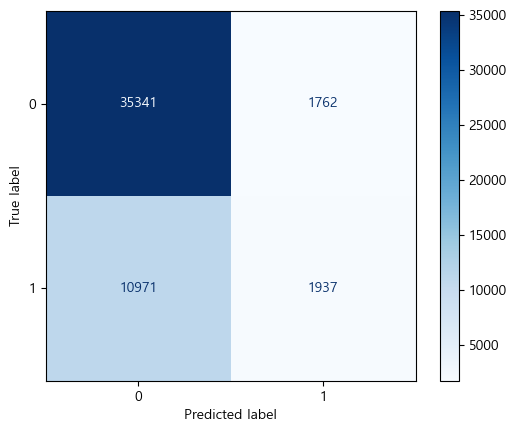

In [13]:
# 모델 초기화
IVF_model = xgb.XGBClassifier(
    n_estimators=4899,
    max_depth=84,
    learning_rate=0.004340384573221108,
    min_child_weight=80,
    subsample=0.6119310335545484,
    colsample_bytree=0.615156874416465,
    reg_alpha=9.97251038795285,
    reg_lambda=7.049953015697085,
    random_state=42,
    objective='binary:logistic',
    eval_metric='auc'
)

# 모델 학습 및 평가
IVF_y_pred, IVF_y_pred_proba = train_and_evaluate(IVF_model, IVF_X_train, IVF_y_train, IVF_X_test, IVF_y_test)

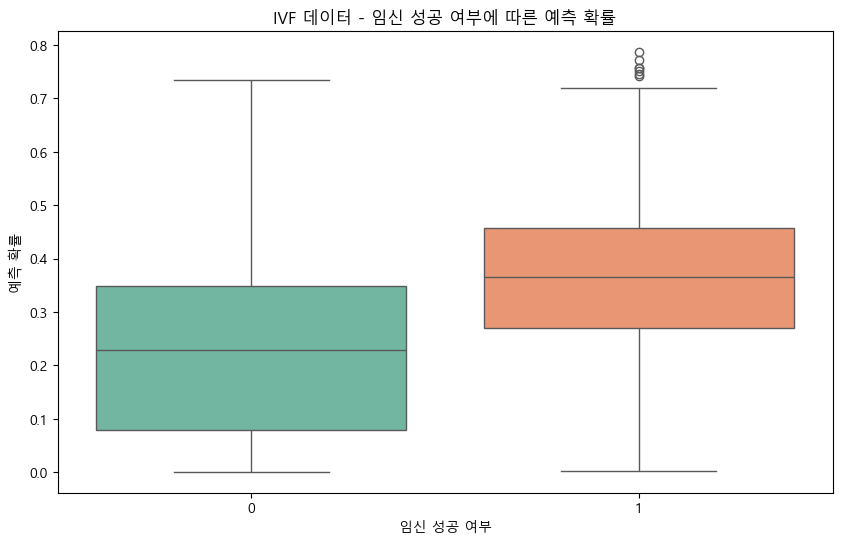

In [14]:
plot_boxplot(IVF_y_test, IVF_y_pred_proba, 'IVF 데이터 - 임신 성공 여부에 따른 예측 확률')

### DI 데이터


--- Model Performance ---
Model Accuracy: 0.8736089030206677
Model F1 Score: 0.0
Model AUC: 0.7130410149878964


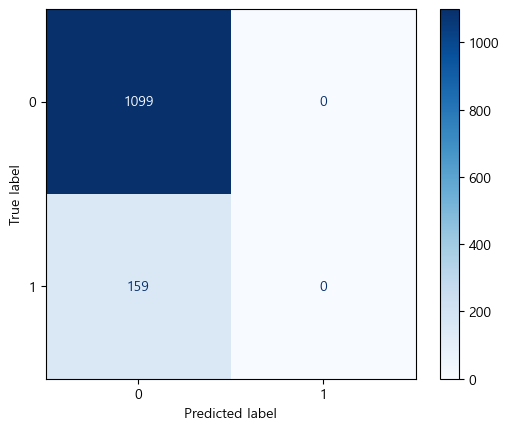

In [15]:
# 모델 초기화
DI_model = xgb.XGBClassifier(
    n_estimators=857,
    max_depth=114,
    learning_rate=0.034131901995736194,
    min_child_weight=77,
    subsample=0.6064673613344926,
    colsample_bytree=0.966893159895088,
    reg_alpha=0.010841307150467409,
    reg_lambda=0.005415126294541269,
    random_state=42,
    objective='binary:logistic',
    eval_metric='auc'
)

# 모델 학습 및 평가
DI_y_pred, DI_y_pred_proba = train_and_evaluate(DI_model, DI_X_train, DI_y_train, DI_X_test, DI_y_test)

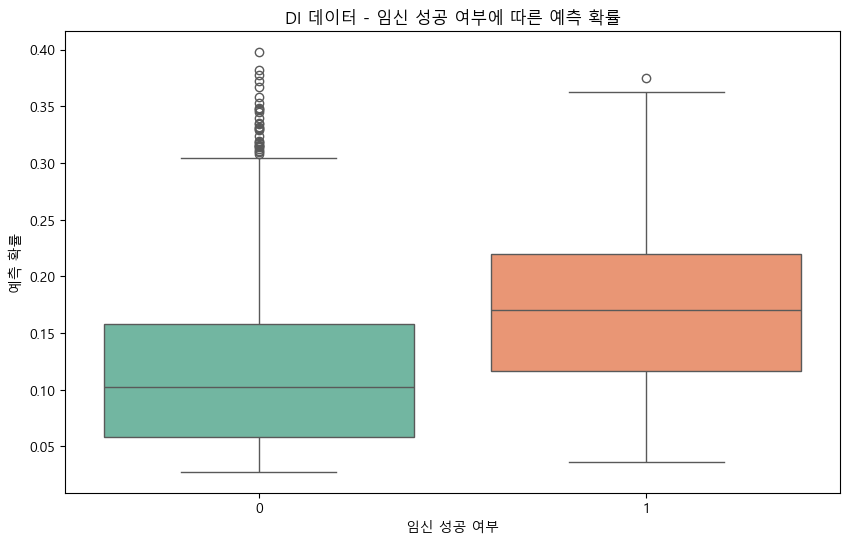

In [16]:
plot_boxplot(DI_y_test, DI_y_pred_proba, 'DI 데이터 - 임신 성공 여부에 따른 예측 확률')

### IVF + DI 데이터


--- Combined Model Performance ---
Model Accuracy: 0.7485420039400027
Model F1 Score: 0.23106286532267684
Model AUC: 0.7384412696141952


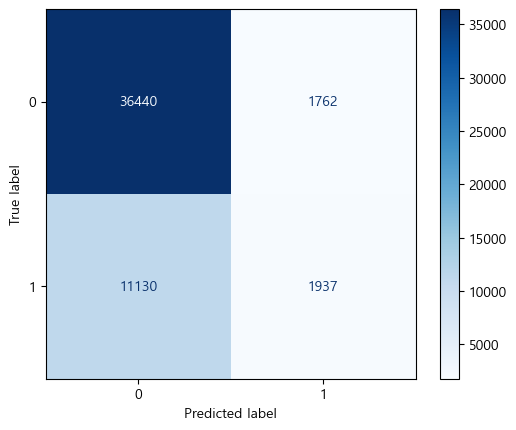

In [17]:
# 예측 결과 병합
y_test = pd.concat([IVF_y_test, DI_y_test])
y_pred = pd.concat([pd.Series(IVF_y_pred, index=IVF_y_test.index), pd.Series(DI_y_pred, index=DI_y_test.index)])
y_pred_proba = pd.concat([pd.Series(IVF_y_pred_proba, index=IVF_y_test.index), pd.Series(DI_y_pred_proba, index=DI_y_test.index)])

# 평가
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
cm = confusion_matrix(y_test, y_pred)

# 결과 출력
print()
print("--- Combined Model Performance ---")
print(f"Model Accuracy: {accuracy}")
print(f"Model F1 Score: {f1}")
print(f"Model AUC: {auc}")

# 혼동 행렬 출력
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=IVF_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

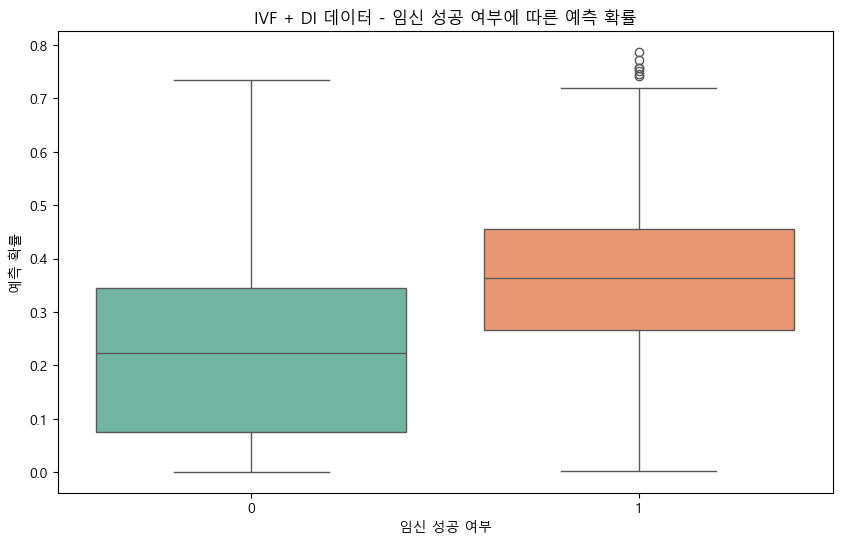

In [18]:
plot_boxplot(y_test, y_pred_proba, 'IVF + DI 데이터 - 임신 성공 여부에 따른 예측 확률')

## 제출

In [19]:
# 모델 학습 및 예측
IVF_model.fit(IVF_X, IVF_y)
IVF_pred_proba = IVF_model.predict_proba(IVF_test.drop('ID', axis=1))[:, 1]

DI_model.fit(DI_X, DI_y)
DI_pred_proba = DI_model.predict_proba(DI_test.drop('ID', axis=1))[:, 1]

In [20]:
# 예측 결과 병합
IVF_test['probability'] = IVF_pred_proba
DI_test['probability'] = DI_pred_proba

# 최종 제출 파일 생성
submission = pd.concat([IVF_test[['ID', 'probability']], DI_test[['ID', 'probability']]], axis=0)
submission = submission.sort_values(by='ID')  

# 제출 파일 저장
submission.to_csv('../submission/submit_xgb.csv', index=False, encoding='utf-8')

.